In [3]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Reshape, Concatenate, Activation, Dense
import keras
import numpy as np
import string
# from progressbar import progressbar
from keras.models import Model
import tensorflow as tf

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# load model
model = VGG16()
model.layers.pop()
# extract final 49x512 conv layer for context vectors
final_conv = Reshape([49,512])(model.layers[-4].output)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

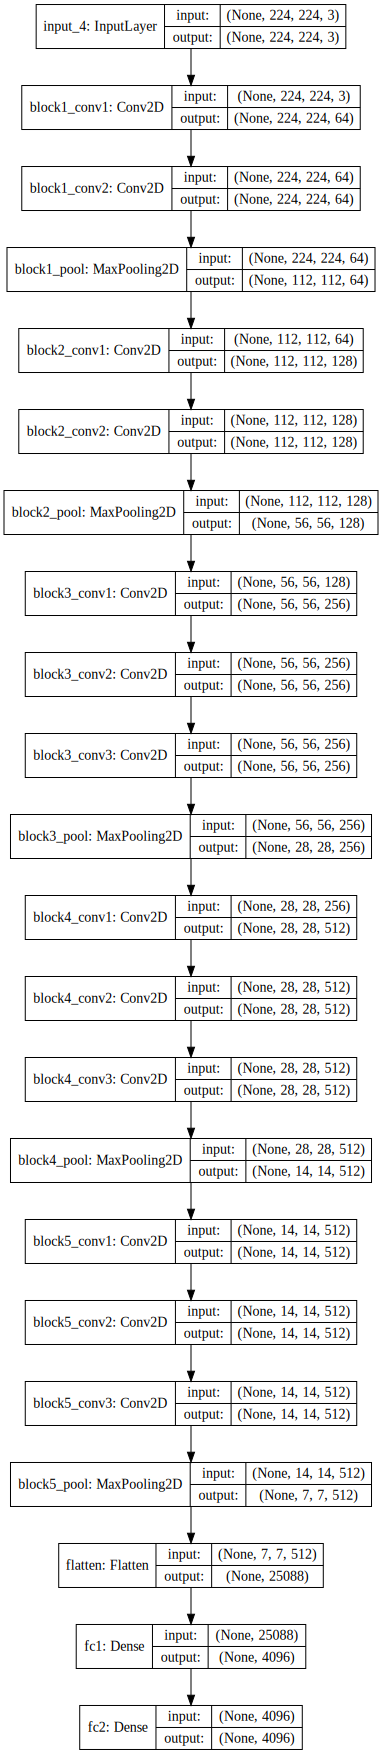

In [8]:
SVG(model_to_dot(model_to_dot, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [9]:
model = VGG16()
# re-structure the model
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
class AttentionModel:
    
    def __init__(self):
        
        # load model
        model = VGG16()
        model.layers.pop()
        # extract final 49x512 conv layer for context vectors
        final_conv = Reshape([49,512])(model.layers[-4].output)
        self.model = Model(inputs=model.inputs, outputs=final_conv)
        print(self.model.summary())
        
        # model parameters
        self.dim_ctx = 512
        self.n_ctx = 49
        self.lstm_cell_dim = 128
        self.lstm_hidden_dim = 128
        
        # cell state MLP
        self.c_mlp_hidden = 256
        
        self.inputs_c = Input(shape=(self.dim_ctx,))
        f_c = Dense(self.c_mlp_hidden,activation="relu")(self.inputs_c)
        self.f_c = Dense(self.lstm_cell_dim,activation=None)(f_c)
        
        # hidden state MLP
        self.h_mlp_hidden = 256
        
        self.inputs_h = Input(shape=(self.dim_ctx,))
        f_h = Dense(self.h_mlp_hidden,activation="relu")(self.inputs_h)
        self.f_h = Dense(self.lstm_hidden_dim,activation=None)(f_h)
        
        # attention/alphas MLP
        self.att_mlp_hidden = 256
        
        self.inputs_att = Input(shape=(self.dim_ctx+self.lstm_hidden_dim,))
        x = Dense(self.att_mlp_hidden,activation="relu")(self.inputs_att)
        x = Dense(1,activation=None)(x)
        self.alphas = Activation("softmax")(x)
        
        self.sess = tf.Session()
        
    # Returns tensors for the initial cell_state and hidden_states
    def init_lstm_states(self,contexts):
        cell_state = self.sess.run(self.f_c,feed_dict={self.inputs_c:contexts})
        hidden_state = self.sess.run(self.f_h,feed_dict={self.inputs_h:contexts})
        return cell_state,hidden_state
    
    # Computes alpha values (attention weights) by passing context vectors + hidden state through MLP
    # Includes hidden state by concatenating to end of alpha values
    def generate_alphas(self,contexts,hidden_state):
        batch_size = contexts.shape[0]
        tiled_hidden_state = tf.tile([[hidden_state]],[batch_size,n_ctx,1])
        concat_input = Concatenate(axis=-1)((contexts,tiled_hidden_state))
        return self.sess.run(self.alphas,feed_dict={self.inputs_att:concat_input})

    # Generates a soft-attention attention vector from alphas & context vectors
    def get_soft_attention_vec(contexts,alphas):
        return contexts*tf.reshape(alphas,[1,-1,1])
    
    # Generates VGG16 features from a batch of images
    def get_features(images):
        return self.sess.run(self.model.output,feed_dict={})
        
        